# Import Dataset from Kaggle

In [3]:
!kaggle datasets download -d aayushkandpal/air-quality-time-series-data-uci

  0% 0.00/1.23M [00:00<?, ?B/s]
100% 1.23M/1.23M [00:00<00:00, 135MB/s]


In [1]:
import zipfile
zip_ref = zipfile.ZipFile('/content/air-quality-time-series-data-uci.zip', 'r')
zip_ref.extractall('tmp')
zip_ref.close()

In [2]:
import pandas as pd
df = pd.read_excel('/content/tmp/AirQualityUCI.xlsx')
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   object        
 2   CO(GT)         9357 non-null   float64       
 3   PT08.S1(CO)    9357 non-null   float64       
 4   NMHC(GT)       9357 non-null   int64         
 5   C6H6(GT)       9357 non-null   float64       
 6   PT08.S2(NMHC)  9357 non-null   float64       
 7   NOx(GT)        9357 non-null   float64       
 8   PT08.S3(NOx)   9357 non-null   float64       
 9   NO2(GT)        9357 non-null   float64       
 10  PT08.S4(NO2)   9357 non-null   float64       
 11  PT08.S5(O3)    9357 non-null   float64       
 12  T              9357 non-null   float64       
 13  RH             9357 non-null   float64       
 14  AH             9357 non-null   float64       
dtypes: datetime64[ns](1),

In [4]:
df_baru = df[['Date', 'RH']]
df_baru = df_baru.dropna()
df_baru.head()

,Date,RH
0,2004-03-10,48.875001
1,2004-03-10,47.700000
2,2004-03-10,53.975000
3,2004-03-10,60.000000
4,2004-03-10,59.575001


In [6]:
df_baru.isnull().sum()

Date    0
RH      0
dtype: int64

# Visual Inspection

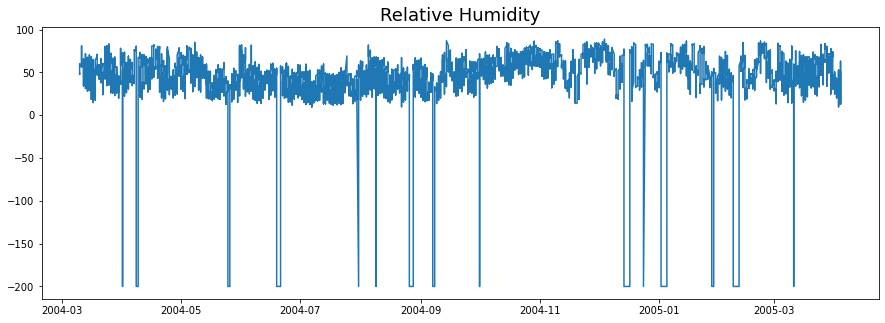

In [9]:
import matplotlib.pyplot as plt

date = df_baru['Date'].values
rh  = df_baru['RH'].values
 
plt.figure(figsize=(15,5))
plt.plot(date, rh)
plt.title('Relative Humidity',
          fontsize=18);

# Prepare Data

In [10]:
df_baru = df_baru.astype({"RH": float})

In [11]:
rh

array([48.87500095, 47.69999981, 53.97500038, ..., 18.34999967,
       13.54999995, 13.125     ])

In [12]:
rh1 = rh.reshape(-1,1)
rh1

array([[48.87500095],
       [47.69999981],
       [53.97500038],
       ...,
       [18.34999967],
       [13.54999995],
       [13.125     ]])

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

min_max_scaler = StandardScaler()
rh = min_max_scaler.fit_transform(rh1)
rh

array([[ 0.18337935],
       [ 0.16043589],
       [ 0.28296361],
       ...,
       [-0.41266181],
       [-0.50638818],
       [-0.51468687]])

# Training and Testing 

In [17]:
from sklearn.model_selection import train_test_split

rh_latih, rh_test = train_test_split(rh, test_size=0.2, shuffle=False)
print(rh_latih.shape, rh_test.shape)

(7485,) (1872,)


In [25]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

train_set = windowed_dataset(rh_latih, window_size=60, batch_size=128, shuffle_buffer=1000)
test_set = windowed_dataset(rh_test, window_size=60, batch_size=128, shuffle_buffer=1000)

# Create Model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
mycallback = EarlyStopping(monitor="val_loss", mode="min", patience=2)

In [36]:
model = Sequential()
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9),
              loss=tf.keras.losses.Huber(), metrics=['mae'])

In [37]:
history = model.fit(train_set, validation_data=(test_set), 
                    epochs=100, callbacks=mycallback)

Epoch 1/100
59/59 [==============================] - 17s 200ms/step - loss: 0.2341 - mae: 0.4920 - val_loss: 0.2702 - val_mae: 0.5133
Epoch 2/100
59/59 [==============================] - 11s 185ms/step - loss: 0.2297 - mae: 0.4834 - val_loss: 0.2655 - val_mae: 0.5047
Epoch 3/100
59/59 [==============================] - 11s 186ms/step - loss: 0.2266 - mae: 0.4768 - val_loss: 0.2616 - val_mae: 0.4979
Epoch 4/100
59/59 [==============================] - 12s 206ms/step - loss: 0.2233 - mae: 0.4709 - val_loss: 0.2579 - val_mae: 0.4922
Epoch 5/100
59/59 [==============================] - 11s 187ms/step - loss: 0.2215 - mae: 0.4669 - val_loss: 0.2552 - val_mae: 0.4873
Epoch 6/100
59/59 [==============================] - 11s 187ms/step - loss: 0.2196 - mae: 0.4634 - val_loss: 0.2530 - val_mae: 0.4836
Epoch 7/100
59/59 [==============================] - 11s 189ms/step - loss: 0.2177 - mae: 0.4595 - val_loss: 0.2511 - val_mae: 0.4803
Epoch 8/100
59/59 [==============================] - 13s 221ms

# Plotting MAE and loss

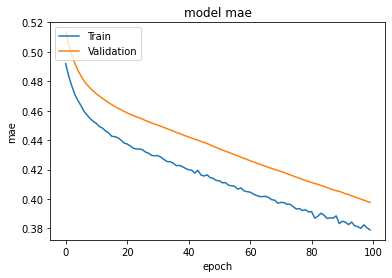

In [40]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

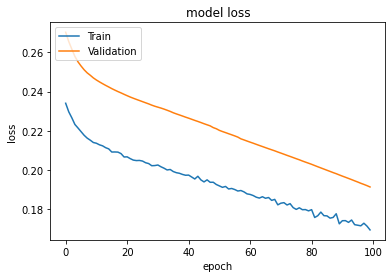

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Threshold MAE

In [42]:
threshold_mae = (rh.max() - rh.min()) * 10/100
print(threshold_mae)

0.5637738839485721
